# Trabajo final de Cosmología de Presición
*para la aprobación de la materia Cosmología de Presición dictada por Claudia Scóccola en 2024*

*por Juan I. Iribarren.*

## **Tema 1:** Evolución del Universo homogéneo y en expansión (background):

1) Elija un conjunto de parámetros cosmológicos, y grafique la evolución del parámetro de Hubble.
Muestre a través de un gráfico, cómo depende de cada uno de los parámetros de densidad.
2) Grafique las distancias de luminosidad, de diámetro angular, y la distancia comóvil.
3) Grafique $a(t)$
4) Grafique $z(t)$, y tome ciertos valores representativos de momentos claves de la evolución del
Universo (BBN, equality, recombinación, reionización, pico de formación estelar (sSFR), época
actual, y algún otro momento que considere relevante), y exprese dichas épocas en tiempo cósmico,
en redshift $z$, en valor del factor de escala $a$, y en escala de energía medida en temperatura $K$.


Comenzaré por algunos pasos que seran comunes a todo el desarrollo del código. primero, importaré algunas librerías.

In [4]:
import classy as classy
from classy import Class

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

cmap = mpl.colormaps['cooper']
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

Importaré el valor de velocidad de la luz de Scipy y luego lo convierto de $m/s$ a $km/h$. Este nos permitirá pasar de unidades naturales a unidades del SI.

In [6]:
from scipy.constants import speed_of_light as c
c = c/1000

Ahora crearé un diccionario que contenga los siguientes parametros cosmologicos extraídos de la Tabla 2 de *Planck 2018 results. VI. Cosmological parameters* <sup>[1]</sup>:

+ $H0 = 100 h = 67,66 \pm 0.42$
+ $\omega_b=\Omega_b h^2= 0,02242 \pm 0.00014$
+ $\omega_{c}=\Omega_{c} h^2= 0,11933 \pm 0.00091$
+ $\tau_{reio} = 0.0561 \pm 0.0071$
+ $n_s = 0.9665 \pm 0.0038$
+ $Y_{He} = 0.2454$


Este dicionario será de utilidad para ingresar estos parametros como input del código de CLASS y para algunos otros cálculos.

Nota: si bien existen sets de datos más nuevos<sup>[2]</sup>, los mismos no aportan una mejor precisión o exatitud para el nivel de analisis que haremos.

In [7]:
planck_18 = {
    'H0': 67.66,
    'ombh2': 0.02242,   ## Omega_b * h**2
    'omch2': 0.11933,  ## Omega_c * h**2
    'tau_reio': 0.0561,
    'A_s': 2.105e-09,
    'n_s': 0.9665,
    'YHe': 0.2454
    }
planck_18['h'] = planck_18['H0']/100
planck_18['Omega_cdm'] = planck_18['omch2']/planck_18['h']**2
planck_18['Omega_b'] = planck_18['ombh2']/planck_18['h']**2


Para el inciso 1, comenzaré definiendo una función permite crear copias de un diccionario de parámetros cambiando uno de ellos. Para ello, debemos darle a la función el diccionario de parámetros originales `ParamDic`, el key correspondiente al valor que queremos variar `KeyStr` y una lista multipricadores `IndexList`. Al final, obtendremos una lista con los nuevos diccionarios y otra con los nuevos valores del parámetro.

In [8]:
def VarParam(ParamDic, KeyStr, IndexList):
    
    ListVariatedDics = []
    NewValues = ParamDic[KeyStr]*np.array(IndexList)
    
    for NV in NewValues:
        ListVariatedDics.append(ParamDic.copy())
        ListVariatedDics[-1][KeyStr] = NV
        
    return ListVariatedDics, NewValues

Tomaré el diccionario con los valores medidos por Planck -los fiduciales- y armaré 4 nuevos diccionarios de parámetros. Dosse encontrarán en la lista `PlanckWithModOb` ellos tendran un valor de $\Omega_b$ con una variación del $\pm 50\%$ respecto a los valores fduciales. Analogamente, los otros dos diccionarios se encontrarán en `PlanckWithModOc` con valores de $\Omega_{cdm}$ modificados en $\pm 50\%$ respecto de los originales. A su vez, guardaré una lista con los valores modificados para los respectivos $\Omega$

In [9]:
PlanckWithModOb, New_Omega_cdm = VarParam(planck_18, "Omega_cdm", [0.5, 1, 1.5])
PlanckWithModOc, New_Omega_b = VarParam(planck_18, "Omega_b", [0.5, 1, 1.5])

Prepararemos ahora una función que a partir de un set de parámetros permite extraer de CLASS las listas generadas por background.c.

In [10]:
def GetBackground(parameters):
    AuxDic = parameters.copy()
    AuxDic.pop("H0",0)
    AuxDic.pop("ombh2",0)
    AuxDic.pop("omch2",0)
    AuxDic.pop("Y_He",0)
    M = Class()
    M.empty()
    M.set(AuxDic)
    M.compute()
    
    return M.get_background()

Ahora calcularé el Background de cada uno de los 5 diccionarios de input creados (`planck_18` y sus modificaciones).

In [11]:
BG_Planck = GetBackground(planck_18)
BG_ModOc = [GetBackground(x) for x in PlanckWithModOc]
BG_ModOb = [GetBackground(x) for x in PlanckWithModOb]

Podemos observar qué objetos devuelve el codigo bacground.c aplicando el método `.keys()`. Vemos que nos provee del $z$, $t$, $\eta$, $H$ en unidades naturales, la distancia comovil, angular y de luminosidad, entre otros.

In [12]:
BG_Planck.keys()

dict_keys(['z', 'proper time [Gyr]', 'conf. time [Mpc]', 'H [1/Mpc]', 'comov. dist.', 'ang.diam.dist.', 'lum. dist.', 'comov.snd.hrz.', '(.)rho_g', '(.)rho_b', '(.)rho_cdm', '(.)rho_lambda', '(.)rho_ur', '(.)rho_crit', '(.)rho_tot', '(.)p_tot', '(.)p_tot_prime', 'gr.fac. D', 'gr.fac. f'])

A partir de estas listas es sencillo graficar $H(z)$. En este caso lo haremos para todo el rango disponible de $z$ y $H$. Veremos que los valores obtenidos de background.c están calculados para $z\in [0,10^{14}]$. Lo cual se remonta muy atrás en el tiempo para los efectos que nos interesan en este momento. Por ello, mas adelante graficaremos en $z\in [0,10^{8}]$ (desde la BBN hasta hoy).

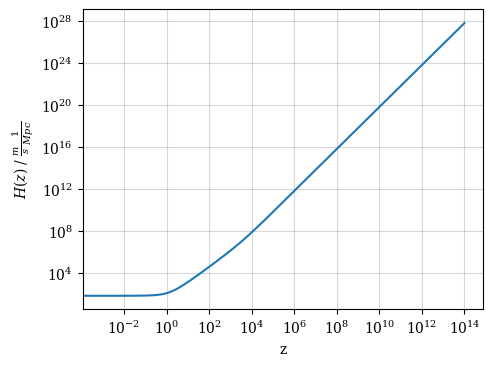

In [13]:
fig = plt.figure(1, figsize=(4, 3))
ax1 = fig.add_axes([0, 0, 1, 1])

ax1.loglog(BG_Planck["z"], BG_Planck["H [1/Mpc]"]*c)

ax1.set_xlabel("z")
ax1.set_ylabel(r"$H(z)$ / $\frac{m}{s} \frac{1}{Mpc}$")
ax1.grid(alpha = 0.5)

Como podemos ver, $H$ tiene un valor casi constante en $H_0$ desde hoy $(z=0)$ hasta $z=1$, coincidiendo aproximadamente con el momento donde en el universo deja de dominar la materia barionica y comienza a dominar la materia oscura. A partir de ahí, $H$ crece varios órdenes de magnitud. Considerando $z_{BBN}=10^8$ entonces $H(BBN) \sim 10^{16}$, a partir de acá el siguiente punto que no interesa es inflación pero este momento se encuentra a redshifts mucho mayores a $10^{14}$. Por esto, en el resto de los gráficos limitaré el dominio a $z\in [0,10^{8}]$

Ahora, graficaré no sólo los valores de $H(z)$ obtenidos a partir de `planck_18` sino también los modificados. Emezaré por graficar `BG_ModOb`, es decir, valores de $\Omega_b$ mayor y menor al fiducial en un 50%.

[(0.1, 10000.0),
 (10.0, 100000000.0),
 None,
 Text(0.5, 1.0, 'Zoom en $z \\to 0$, $z \\sim 1$ y $z \\sim z_{eq}$')]

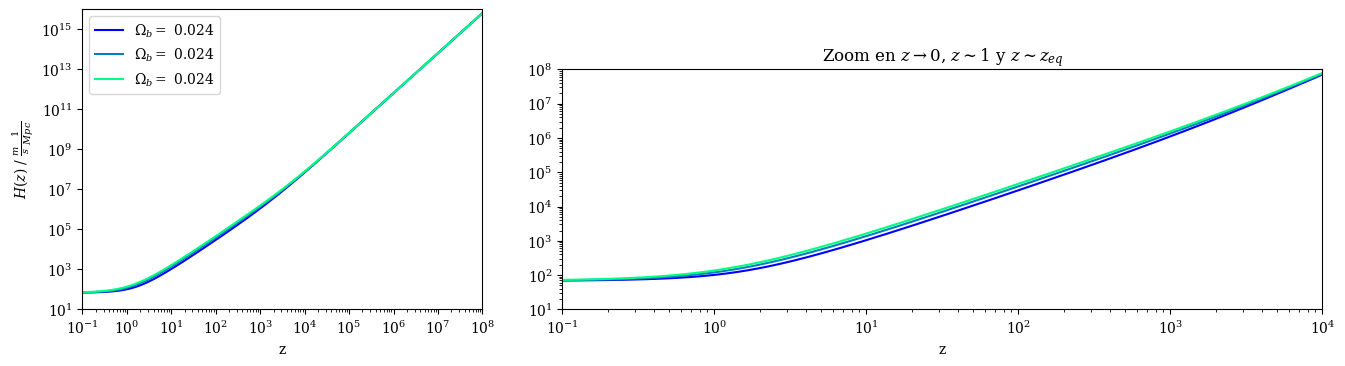

In [14]:
fig = plt.figure(1, figsize=(4, 3))
ax1 = fig.add_axes([0, 0, 1, 1])
ax2 = fig.add_axes([1.2, 0, 1.9, 0.8])

for ax in fig.axes:
    for i in range(len(BG_ModOb)):
        ax.loglog(BG_ModOb[i]["z"], BG_ModOb[i]["H [1/Mpc]"]*c, label = r"$\Omega_b =$ "+str(round(New_Omega_b[0],3)), color = cmap(i/(3-1)))

    ax.set_xlabel("z")

ax1.set_ylabel(r"$H(z)$ / $\frac{m}{s} \frac{1}{Mpc}$")

ax1.set(xlim=(1e-1, 1e8), ylim=(1e1, 1e16), autoscale_on=False)
ax1.legend()

ax2.set(xlim=(1e-1, 1e4), ylim=(1e1, 1e8), autoscale_on=False, title=r'Zoom en $z \to 0$, $z \sim 1$ y $z \sim z_{eq}$')

    

Podemos apreciar que hoy en $z\ll 1$, independientemente del valor de $\Omega_b$, $H$ tiende a $H_0 \sim 67$, lo cual es razonable puesto que es el valor que se mide hoy. A medida que z se acerca a 1 podemos notar la diferencia en $H$ para cada caso,siendo esta creciente con $\Omega_b$. Podemos ver que el mencionado efecto se revierte en $z$ entre $10^3$ y $10^4$, coincidiendo con equality. Es decir, cambiar la componente de materia bariónica en el univeso se aprecia especialmente en la época dominada por materia. A su vez, en esta época, $H$ resulta creciente con la componente de materia bariónica.

Ahora repetire el proceso, pero esta vez variando $\Omega_c$ en $\pm 50\%$.

[(1000.0, 5000.0),
 (1000000.0, 30000000.0),
 None,
 Text(0.5, 1.0, '$z \\sim z_{eq}$')]

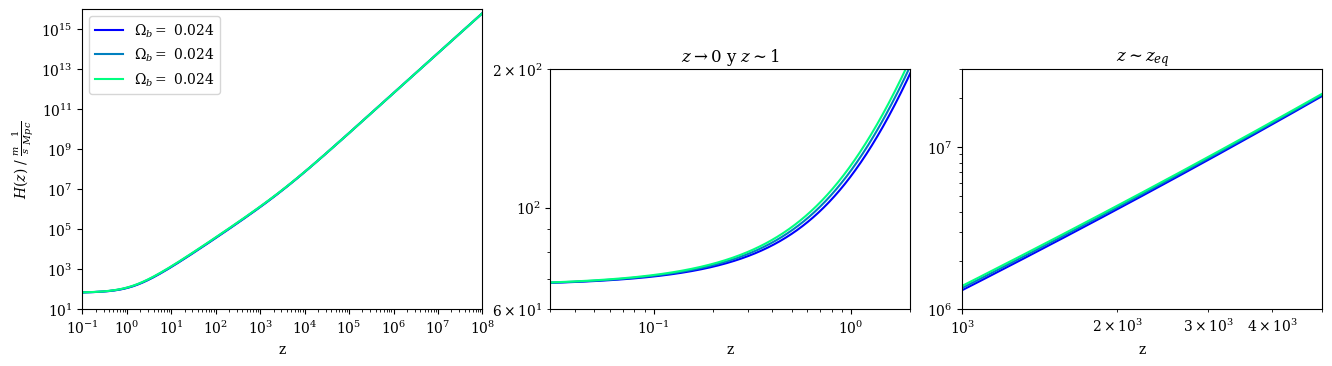

In [15]:
fig = plt.figure(1, figsize=(4, 3))
ax1 = fig.add_axes([0, 0, 1, 1])
ax2 = fig.add_axes([1.17, 0, .9, .8])
ax3 = fig.add_axes([2.2, 0, .9, .8])

for ax in fig.axes:
    for i in range(len(BG_ModOc)):
        ax.loglog(BG_ModOc[i]["z"], BG_ModOc[i]["H [1/Mpc]"]*c, label = r"$\Omega_b =$ "+str(round(New_Omega_b[0],3)), color = cmap(i/(3-1)))

    ax.set_xlabel("z")

ax1.set_ylabel(r"$H(z)$ / $\frac{m}{s} \frac{1}{Mpc}$")

ax1.set(xlim=(1e-1, 1e8), ylim=(1e1, 1e16), autoscale_on=False)
ax1.legend()

ax2.set(xlim=(3e-2, 2e0), ylim=(6e1, 2e2), autoscale_on=False, title=r'$z\to 0 $ y $z\sim 1$')

ax3.set(xlim=(1e3, 5e3), ylim=(1e6, 3e7), autoscale_on=False, title=r'$z \sim z_{eq}$')

En este caso la diferencia es más sutíl, lo que me obligó a hacer dos zoom's más profundos sobre distintas secciones del gráfico. Así como antes, durante la época dominada por la materia (entre $z\sim 1$ y $z \sim z_{eq}$), se nota que el aumento de la densidad de materia oscura $\Omega_{cdm}$ provoca un aumento de la constante de hubble $H$. En $z \to 0$ se ve que $H \to H_0$ y, por otro lado, para $z > z_{eq}$ se ve que H tiene la misma dependencia con z, sin importar $\Omega_{cdm}$.

Ahora procederemos al inciso 2. Para ello usaremos los valores devueltos por background.c calculado a partir de los parámetros de planck, `BG_Planck`. De allí vimos que se pueden obtener las distancias comoviles, de luminosidad y angular asi que podremos graficarlas facilmente. Comencemos por la distancia de luminosidad:

Text(0, 0.5, '$d_L(z)$')

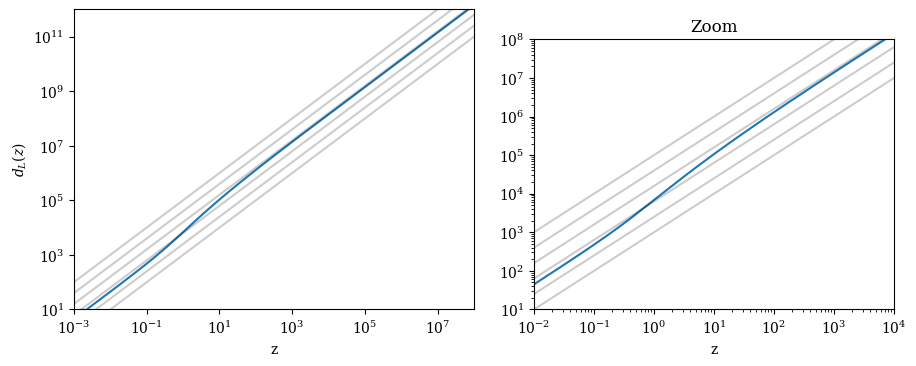

In [16]:
fig = plt.figure(1, figsize=(4, 3))
ax1 = fig.add_axes([0, 0, 1, 1])
ax2 = fig.add_axes([1.15, 0, 0.9, 0.9])

for ax in fig.axes:
    ax.set_xlabel("z")
    ax.loglog(BG_Planck["z"], BG_Planck["lum. dist."])
    for b in np.logspace(3, 5, 6):
        ax.loglog(BG_Planck["z"], BG_Planck["z"]*b, "k-", alpha = 0.2)

ax1.set(xlim=(1e-3, 1e8), ylim=(1e1, 1e12))

ax2.set(xlim=(1e-2, 1e4), ylim=(1e1, 1e8),  title=r'Zoom')

ax1.set_ylabel(r"$d_L(z)$")

Al gráfico le agregué unas lineas rectas paralelas para identificar fácilmente las tndencias que mencionaré a continuación.
Vemos que $d_L$ crece con una pendiente determinada hasta $z\sim 10^1$ donde, primero, toma una pendiente más pronunciada y finalmente vemos una recta a aproximadamente $45^\circ$. Como el gráfico se encuentra en escala logarítmica, existe una proporcinalidad de $d_L$ con $z$ a partir de $z \sim 1$.
Considerando que $d_L = \frac{r_{com}}{a} = (1+z)r_{com}$, es entendible el comportamiento anterior. Para $z \ll 1$ se tiene que $d_L \sim r_{com}$, mientras que para $z\gg 1$ obtenemos $d_L\sim z r_{com}$.


Procederé haciendo lo mismo con la distancia angular, $d_\theta$.

Text(0, 0.5, '$d_\\theta(z)$')

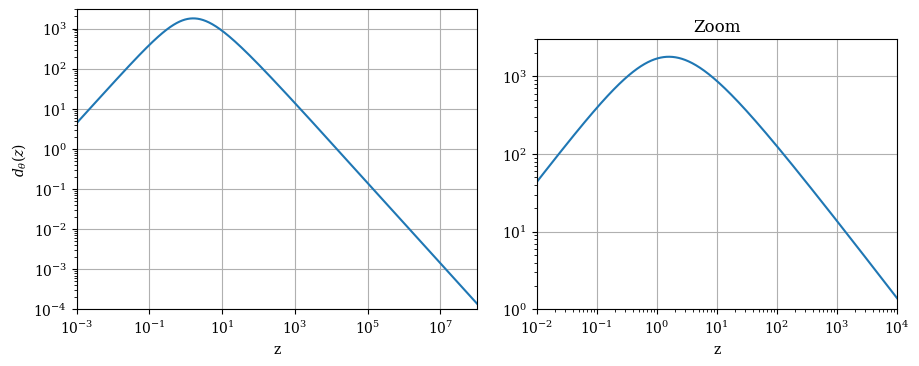

In [17]:
fig = plt.figure(1, figsize=(4, 3))
ax1 = fig.add_axes([0, 0, 1, 1])
ax2 = fig.add_axes([1.15, 0, 0.9, 0.9])

for ax in fig.axes:
    ax.set_xlabel("z")
    ax.grid()
    ax.loglog(BG_Planck["z"], BG_Planck['ang.diam.dist.'])

ax1.set(xlim=(1e-3, 1e8), ylim=(1e-4, 3e3))

ax2.set(xlim=(1e-2, 1e4), ylim=(1e0, 3e3), autoscale_on=False, title=r'Zoom')

ax1.set_ylabel(r"$d_\theta(z)$")

Encontramos que $d_\theta(z)$ tiene un máximo en $z\sim 1$.
Considerando que $d_\theta = \frac{r_{com}}{1+z}$ en un universo plano como el que estamos trabajando, es normal que cuando $z \gg 1$ tengamos $d_\theta \sim r_{com} z^{-1}$ lo que se ve en el gráfico como una recta de pendiente $-1$. Esa relaxión también explica el máximo.

 Ahora armamos el mismo gráfico para la distancia comovil $r_{com}$

Text(0, 0.5, '$r_{com}(z)$')

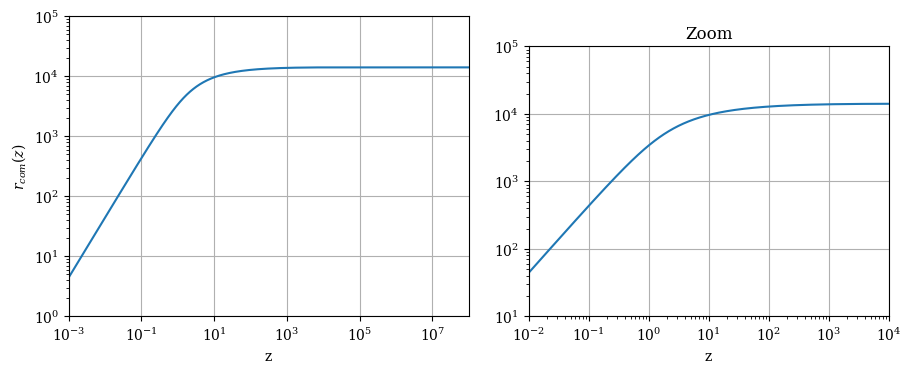

In [18]:
fig = plt.figure(1, figsize=(4, 3))
ax1 = fig.add_axes([0, 0, 1, 1])
ax2 = fig.add_axes([1.15, 0, 0.9, 0.9])

for ax in fig.axes:
    ax.set_xlabel("z")
    ax.grid()
    ax.loglog(BG_Planck["z"], BG_Planck['comov. dist.'])

ax1.set(xlim=(1e-3, 1e8), ylim=(1e0, 1e5))

ax2.set(xlim=(1e-2, 1e4), ylim=(1e1, 1e5), autoscale_on=False, title=r'Zoom')

ax1.set_ylabel(r"$r_{com}(z)$")

Podemos ver que esta crece rápidamente desde $z\to 0$ hasta $z\sim 1$ y luego continua su crecimiento a un ritmo menor (queda casi constante).
Dada la expresión de la distancia comovil
$$r_{com}(z)=\int_0^z \frac{dz'}{H(z')}$$
y la forma de $H(z)$ que vimos antes, podemos ver por qué $r_{com}(z)$ se comporta de esta manera. En $z \ll 1$ vimos que $H \sim H_0$ por ende tenemos $r_{com} \sim \frac{z}{H_0}$. Mientras que si $z \gg 1$ teníamos $H \sim H_0 z^{3/2}$ (para el rango en el que estamos trabajando), entonces $r_{com} \sim H_0 \frac{2}{5}z^\frac{2}{5}$

Propongo ahora hacer la comparación entre las tres distancias presentadas.

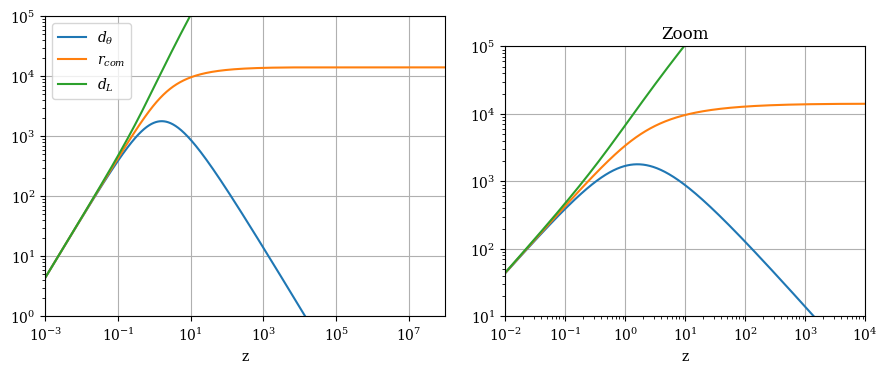

In [19]:
fig = plt.figure(1, figsize=(4, 3))
ax1 = fig.add_axes([0, 0, 1, 1])
ax2 = fig.add_axes([1.15, 0, 0.9, 0.9])

for ax in fig.axes:
    ax.set_xlabel("z")
    ax.grid()
    ax.loglog(BG_Planck["z"], BG_Planck['ang.diam.dist.'], label = r"$d_\theta$")
    ax.loglog(BG_Planck["z"], BG_Planck['comov. dist.'], label = r"$r_{com}$")
    ax.loglog(BG_Planck["z"], BG_Planck["lum. dist."], label = r"$d_L$")

ax1.set(xlim=(1e-3, 1e8), ylim=(1e0, 1e5))

ax2.set(xlim=(1e-2, 1e4), ylim=(1e1, 1e5), autoscale_on=False, title=r'Zoom')

ax1.legend()


Aqui encontramos que las tres distancias analizadas (angular, comóvil y de luminosidad) tienen comportamientos similares en $z<1$ pero diferentes cuando $z>1$, siendo $d_\theta$ decreciente, $r_{com}$ casi constante y $d_L$ creciente. con esto hemos podido recuperar la figura XX del Dodelson.

Siguiendo con el inciso 3, precisamos graficar $a(t)$, para ello necesitamos dos listas o arrrays, uno de $t$ y otro de sus correspondientes valores de $a$. La primera se puede obtener desde el codigo de background.c pues tiene un parámetro llamado tiempo propio. Tambien en background.c teniamos los $z$ y usando que $a=\frac{1}{1+z}$ podemos obtener una lista de $a$ con correspondencia 1 a 1 con la lista de $t$.

Text(0, 0.5, '$a(t)$')

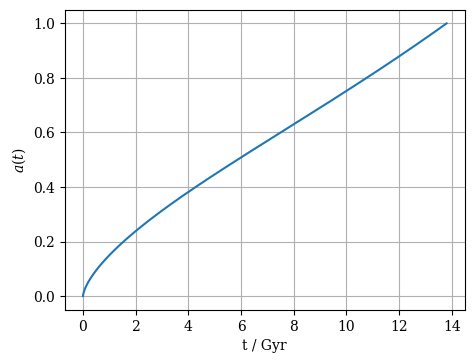

In [20]:
fig = plt.figure(1, figsize=(4, 3))
ax1 = fig.add_axes([0, 0, 1, 1])
ax1.grid()

a = 1/(1+(BG_Planck["z"]))

ax1.plot(BG_Planck["proper time [Gyr]"], a)

ax1.set_xlabel("t / Gyr")

ax1.set_ylabel(r"$a(t)$")

Podemos ver que $a$ experimenta un crecimiento repentino en los primeros momentos del universo, lo que conocemos como inflación. En este punto el $a\propto t^{1/2}$ y esto implica que $\dot{a} \to \infty$ cuando $t\to 0$ y llegando a la epoca actual se empieza a notar el crecimiento exponencial del factor de crecimiento, puesto que recordemos $a \propto e^{H_0t}$

Para el último inciso, comenzaré por establecer los momentos relevantes solicitados a partir de su z, obtenido desde la bibliografía <sup>[1,3,4]</sup>, y armando un diccionario a partir de eso.

In [287]:
z_BBN = 10e8 #https://arxiv.org/pdf/1707.01004, p.13
z_equality = 3387 #https://arxiv.org/pdf/1807.06209, Table 2
z_recombination = 1089.80 #https://arxiv.org/pdf/1807.06209, Table 2
z_reionization = 7.82 #https://arxiv.org/pdf/1807.06209, Table 2
z_sSFR = 1.85 #https://arxiv.org/pdf/1403.0007, p.63 
z_today = 0 

z_relevant = {"BBN":z_BBN, "equality":z_equality,
    "recombination":z_recombination,
    "reionization":z_reionization,
    "sSFR":z_sSFR,"today":z_today}

Ahora graficaré $z(t)$ y añadiré los momentos del diccionario que elaboré previamente.

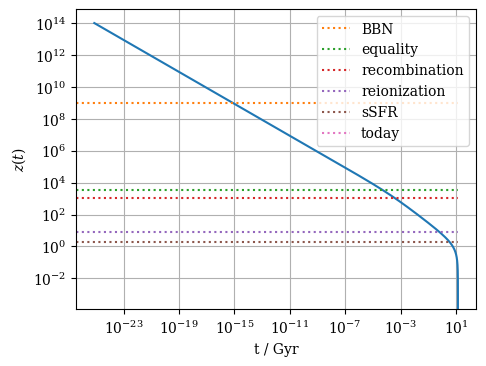

In [288]:
fig = plt.figure(1, figsize=(4, 3))
ax1 = fig.add_axes([0, 0, 1, 1])

ax1.loglog(BG_Planck["proper time [Gyr]"], BG_Planck["z"])

for label, y in z_relevant.items():
    ax1.plot([0, 13.8], [y]*2, linestyle=":", label = label)

ax1.legend()

ax1.set_xlabel("t / Gyr")

ax1.set_ylabel(r"$z(t)$")

ax1.grid()


Como podemos ver, $z$ describe una curva monotamente decreciente y cuya pendiente se vuelve más necgativa cerca de hoy, $t\sim 13.8\ Gyr$. La recombinación se da en $z\sim 10^{11}$ que pareciera equivaler a $t \sim 10^{-19}\ Gyr$. Equality se da en $z\sim 3400$ y parece corresponder a $t \sim 10^{-4}\ Gyr$. Recombinación, reionización y sSFR se dan entre $0,1\ Gyr$ y $1 Gyr$. Naturalmente, la epoca actual no se ve en el grafico puesto que el mismo está en escala logarítmica para mejor visualización y $z_{hoy}=0$.

Antes de hacer la tabla de conversión, usaré una función de interpolación de Scipy para poder obtener la inversa de la función que se ve en el grfico anterior. Es decir, usaré una función de interpolación para poder evaluar z en distintos tiempos.

In [289]:
from scipy.interpolate import interp1d

t_of_z = interp1d(BG_Planck["z"], BG_Planck["proper time [Gyr]"])


Ahora construiré la tabla de equivalencias. Comenzaré por crear un DataFrame de Pandas que tenga como indicies a cada uno de los momentos (que también son los indices del diccionario de los z relevantes). Luego ingresaré los valores. Calcularé el $a$ correspondiente a partir de $a=\frac{1}{1+z}$. Considerando que $T\propto \frac{1}{a}$ y conociendo que $T_{hoy}=2,7255\ K$ por el CMB y $a_{hoy}=1$ por normalización, podemos obtener $T$ a partit de $a$. Por último, usando la función creada antes, podemos encontrar el tiempo propio $t$ para los $z$ relevantes.

In [290]:
from pandas import DataFrame

Equivalences = DataFrame(index= z_relevant.keys())

Equivalences["z"] = z_relevant.values()

Equivalences["a"] = 1/(1+Equivalences["z"])

Equivalences["T [K]"] = 2.7255/Equivalences["a"]

Equivalences["t [Gyr]"] = t_of_z(Equivalences["z"])

Equivalences

,z,a,T [K],t [Gyr]
BBN,1.000000e+09,1.000000e-09,2.725500e+09,7.559513e-16
equality,3.387000e+03,2.951594e-04,9.233994e+03,5.143515e-05
recombination,1.089800e+03,9.167583e-04,2.972975e+03,3.723732e-04
reionization,7.820000e+00,1.133787e-01,2.403891e+01,6.582186e-01
sSFR,1.850000e+00,3.508772e-01,7.767675e+00,3.538876e+00
today,0.000000e+00,1.000000e+00,2.725500e+00,1.380412e+01


Finalmente, me parece interesante usar las mismas relaciones para graficar $z$, $a$ y $T$ como funciones de $t$.

Text(0.5, 0, 't / Gyr')

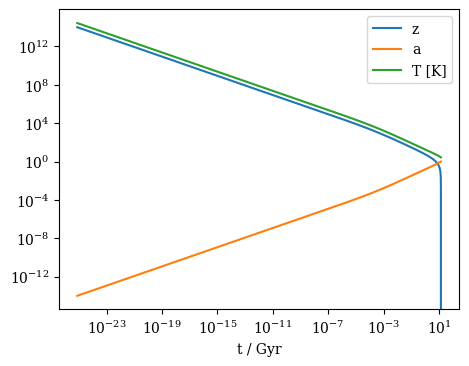

In [291]:
fig = plt.figure(1, figsize=(4, 3))
ax1 = fig.add_axes([0, 0, 1, 1])

ax1.loglog(BG_Planck["proper time [Gyr]"], BG_Planck["z"], label = "z")
ax1.loglog(BG_Planck["proper time [Gyr]"], 1/(1+BG_Planck["z"]), label = "a")
ax1.loglog(BG_Planck["proper time [Gyr]"], 2.7255*(1+BG_Planck["z"]), label = "T [K]")

ax1.legend()

ax1.set_xlabel("t / Gyr")


## **Tema 2:** Formación de estructuras

1) Grafique el espectro de potencias de la materia, para distintos parámetros cosmológicos. Cuales son los relevantes, que cambian el aspecto del P(k)? Describa dichos cambios.
2) Grafique la evolución de un modo de perturbación \delta_m(k), para distintos valores de k. Cómo se hace para determinar la condición inicial?


In [346]:
ModObParams, ModObValues = VarParam(planck_18, "Omega_b", [0.95, 1, 1.05])
ModOcdmParams, ModOcdmValues = VarParam(planck_18, "Omega_cdm", [0.95, 1, 1.05])
ModnsParams, ModnsValues = VarParam(planck_18, "n_s", [0.9, 1, 1.1])
ModtreioParams, ModtreioValues = VarParam(planck_18, "tau_reio", [0.9, 1, 1.1])
ModAsParams, ModAsValues = VarParam(planck_18, "A_s", [0.9, 1, 1.1])

In [341]:
def Get_Pk(params, k_min, k_max):

        AuxDic = params.copy()
        AuxDic.pop("H0",0)
        AuxDic.pop("ombh2",0)
        AuxDic.pop("omch2",0)
        AuxDic.pop("YHe",0)
        
        M = Class()
        M.empty()
        
        M.set(AuxDic)
        M.set({'output':'mPk',
                'z_max_pk': Equivalences["z"]["recombination"]})
        M.compute()
        
        ClassResults = []
        k_space = np.logspace(k_min, k_max, 10000)
        for k in k_space:
                ClassResults = np.append(ClassResults, M.get_pk_all(k, 0))
                
        return k_space, ClassResults

In [342]:
Pk = Get_Pk(planck_18, -3, 0)

Text(0, 0.5, '$P_k$ / $(\\frac{Mpc}{h})^3$')

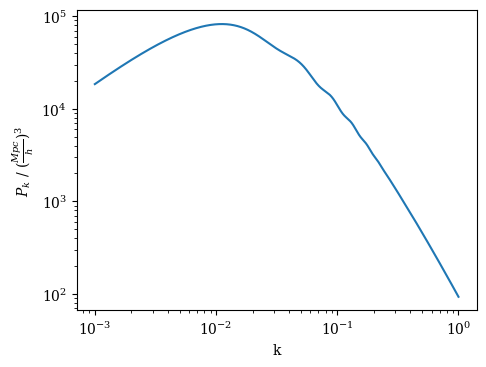

In [344]:
fig = plt.figure(1, figsize=(4, 3))
ax1 = fig.add_axes([0, 0, 1, 1])


ax1.loglog(Pk[0], Pk[1])

ax1.set_xlabel("k")
ax1.set_ylabel(r"$P_k$ / $(\frac{Mpc}{h})^3$")

In [348]:
ModObPks = [Get_Pk(x, -3, 0) for x in ModObParams]
ModOcPks = [Get_Pk(x, -3, 0) for x in ModObParams]
ModnsPks = [Get_Pk(x, -3, 0) for x in ModObParams]
ModtreioPks = [Get_Pk(x, -3, 0) for x in ModObParams]
ModAsPks = [Get_Pk(x, -3, 0) for x in ModObParams]

Text(0, 0.5, '$P_k$ / $(\\frac{Mpc}{h})^3$')

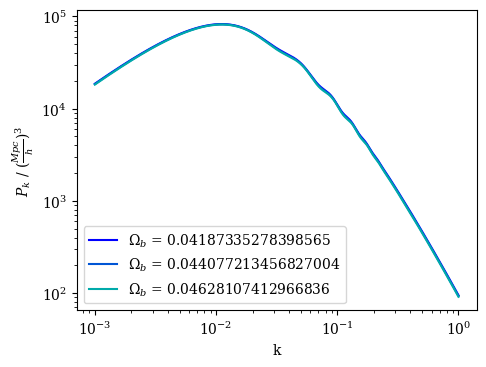

In [354]:
fig = plt.figure(1, figsize=(4, 3))
ax1 = fig.add_axes([0, 0, 1, 1])

j = 0
for i in ModObPks:
    
    ax1.loglog(i[0], i[1], label =r"$\Omega_b$ = "+str(ModObValues[j]), color = cmap(j/len(ModObPks)))
    j += 1

ax1.legend()
ax1.set_xlabel("k")
ax1.set_ylabel(r"$P_k$ / $(\frac{Mpc}{h})^3$")

Text(0, 0.5, '$P_k$ / $(\\frac{Mpc}{h})^3$')

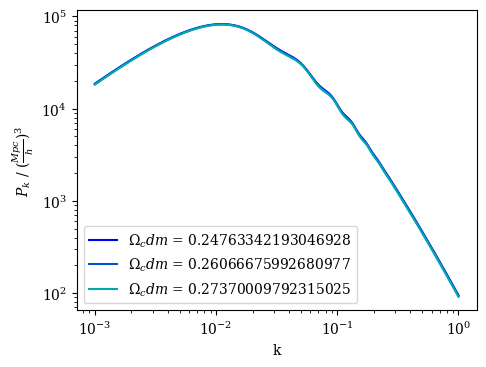

In [355]:
fig = plt.figure(1, figsize=(4, 3))
ax1 = fig.add_axes([0, 0, 1, 1])

j = 0
for i in ModOcPks:
    
    ax1.loglog(i[0], i[1], label =r"$\Omega_cdm$ = "+str(ModOcdmValues[j]), color = cmap(j/len(ModOcPks)))
    j += 1

ax1.legend()
ax1.set_xlabel("k")
ax1.set_ylabel(r"$P_k$ / $(\frac{Mpc}{h})^3$")

Text(0, 0.5, '$P_k$ / $(\\frac{Mpc}{h})^3$')

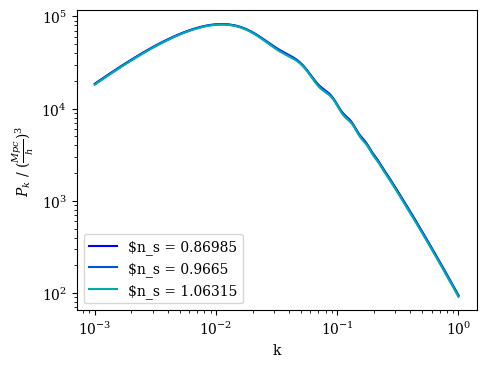

In [356]:
fig = plt.figure(1, figsize=(4, 3))
ax1 = fig.add_axes([0, 0, 1, 1])

j = 0
for i in ModnsPks:
    
    ax1.loglog(i[0], i[1], label =r"$n_s$ = "+str(ModnsValues[j]), color = cmap(j/len(ModnsPks)))
    j += 1

ax1.legend()
ax1.set_xlabel("k")
ax1.set_ylabel(r"$P_k$ / $(\frac{Mpc}{h})^3$")

Text(0, 0.5, '$P_k$ / $(\\frac{Mpc}{h})^3$')

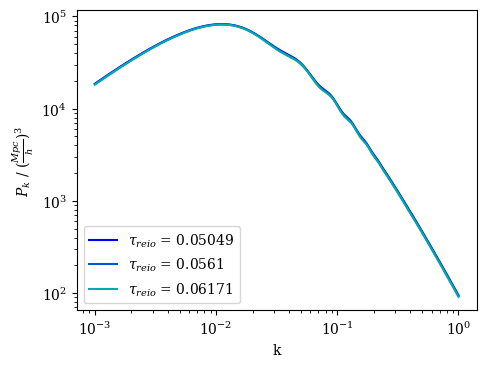

In [357]:
fig = plt.figure(1, figsize=(4, 3))
ax1 = fig.add_axes([0, 0, 1, 1])

j = 0
for i in ModtreioPks:
    
    ax1.loglog(i[0], i[1], label =r"$\tau_{reio}$ = "+str(ModtreioValues[j]), color = cmap(j/len(ModtreioPks)))
    j += 1

ax1.legend()
ax1.set_xlabel("k")
ax1.set_ylabel(r"$P_k$ / $(\frac{Mpc}{h})^3$")

Text(0, 0.5, '$P_k$ / $(\\frac{Mpc}{h})^3$')

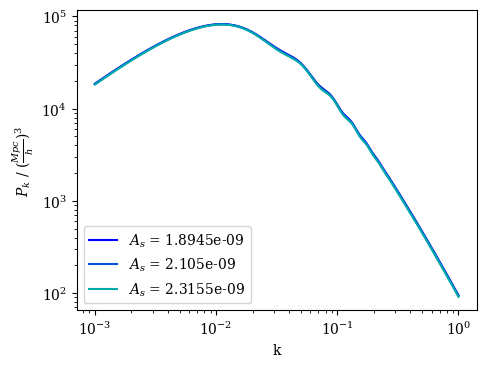

In [358]:
fig = plt.figure(1, figsize=(4, 3))
ax1 = fig.add_axes([0, 0, 1, 1])

j = 0
for i in ModAsPks:
    
    ax1.loglog(i[0], i[1], label =r"$A_s$ = "+str(ModAsValues[j]), color = cmap(j/len(ModAsPks)))
    j += 1

ax1.legend()
ax1.set_xlabel("k")
ax1.set_ylabel(r"$P_k$ / $(\frac{Mpc}{h})^3$")

In [292]:
def Get_delta_m(params, k):
        k_str = ",".join(map(str, k))
        AuxDic = params.copy()
        AuxDic.pop("H0",0)
        AuxDic.pop("ombh2",0)
        AuxDic.pop("omch2",0)
        M = Class()
        M.empty()
        M.set(AuxDic)
        M.set({'output':'mPk,mTk',
                'k_output_values':k_str,
                'compute damping scale':'yes',
                'gauge':'newtonian'})
        M.compute()
        ClassResults = M.get_perturbations()
        print(len(ClassResults["scalar"]))
        Results = {}
        for i in range(len(ClassResults["scalar"])):
                Single_k_result = ClassResults["scalar"][i]
                a = Single_k_result["a"]
                delta_m_norm =  -(Single_k_result["delta_b"]+Single_k_result["delta_cdm"])/3/Single_k_result["phi"][0]
                delta_m_calc =  (3/5)*k[i]**2*Single_k_result["a"]/(params["Omega_b"]+params["Omega_cdm"])/params["H0"]*Single_k_result["phi"]/Single_k_result["phi"][0]*10**9
                Results[str(k[i])] = [a, delta_m_norm, delta_m_calc]
                
        return Results

In [293]:
delta_m_evolution_for_k = Get_delta_m(planck_18, [0.001,0.01,0.1,1, 10])

5


Text(0, 0.5, '$\\delta_m(k,\\eta) / \\Phi (k, 0)$')

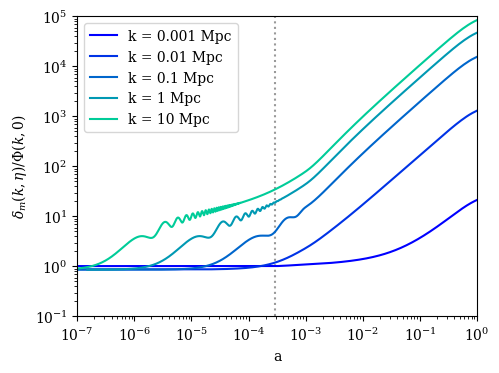

In [296]:
fig = plt.figure(1, figsize=(4, 3))
ax1 = fig.add_axes([0, 0, 1, 1])

ax1.axvline(x=Equivalences["a"]["equality"], color = "k", ls = ":", alpha=0.4)

j = 0
for i in delta_m_evolution_for_k.keys():
    
    ax1.loglog(delta_m_evolution_for_k[i][0], delta_m_evolution_for_k[i][1], label ="k = "+i+" Mpc", color = cmap(j/len(delta_m_evolution_for_k)))
    j += 1



ax1.legend()
ax1.set(xlim=[1e-7,1e0], ylim=[1e-1,1e5])
ax1.set_xlabel("a")
ax1.set_ylabel(r"$\delta_m(k,\eta) / \Phi (k, 0)$")


Text(0, 0.5, '$\\delta_m(k,\\eta) / \\Phi (k, 0)$')

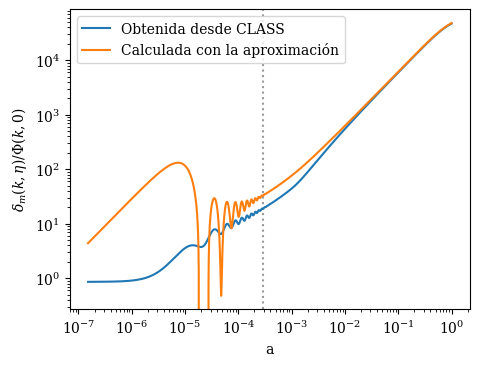

In [297]:
fig = plt.figure(1, figsize=(4, 3))
ax1 = fig.add_axes([0, 0, 1, 1])

ax1.axvline(x=Equivalences["a"]["equality"], color = "k", ls = ":", alpha=0.4)

ax1.loglog(delta_m_evolution_for_k["1"][0], delta_m_evolution_for_k["1"][1], label ="Obtenida desde CLASS")
ax1.loglog(delta_m_evolution_for_k["1"][0], delta_m_evolution_for_k["1"][2], label ="Calculada con la aproximación")


ax1.legend()
ax1.set_xlabel("a")
ax1.set_ylabel(r"$\delta_m(k,\eta) / \Phi (k, 0)$")

## **Tema 3:** Fondo Cósmico de Radiación

1) Elija un conjunto de parámetros cosmológicos para el modelo estándar LCDM (\Lambda CDM). Puede tomar algún conjunto de valores de Planck Legacy Archive, por ejemplo de acá: http://pla.esac.esa.int/pla/#cosmology. Grafique el espectro angular de anisotropías del FCR, tanto para la temperatura como para la polarización (modos E y B).
2) Indique a qué valores de escala angular (\ell) aparecen los picos acústicos, y cual es la amplitud del espectro en cada uno de dichos picos. Compare la amplitud del espectro de temperatura, y de la polarización (tanto modo E como modo B), por ejemplo, haciendo el cociente de la amplitud en los picos. Describa.
3) Aumente y disminuya el valor de cada uno de los parámetros cosmológicos en un \pm 5%, y en un \pm 10%, y estudie como cambian los espectros. Comente. Haga los cambios de a uno por vez, y deje los demás parámetros en su valor fiducial. (Nota: \pm en latex significa +/-)
4) Cómo se comparan los espectros con o sin lensing gravitacional? A qué se debe dicho efecto?


Defino una funcion que calcule los $C_l$ para lasperturbaciones escalares en 

https://www.aanda.org/articles/aa/full_html/2021/03/aa39585-20/aa39585-20.html 

Será necesario darle valores a

In [29]:
def Get_Cls(params, l_max_s, l_max_t):
    AuxDic = params.copy()
    AuxDic.pop("H0",0)
    AuxDic.pop("ombh2",0)
    AuxDic.pop("omch2",0)
    AuxDic.pop("Y_He",0)
    M = Class()
    M.empty()
    M.set(AuxDic)
    M.set({'output':'tCl,pCl','modes':'s','lensing':'no',
        'l_max_scalars':l_max_s})
    M.compute()
    Cls = M.raw_cl(l_max_s)
    
    M.empty() # reset input parameters to default, before passing a new parameter set
    AuxDic.pop("n_s",0)
    M.set(AuxDic)
    M.set({'output':'tCl,pCl','modes':'t','lensing':'no','r':0.044,'n_t':0,
        'l_max_tensors':l_max_t})
    M.compute()
    Clt = M.raw_cl(l_max_t)
    
    ell = Cls['ell']
    ellt = Clt['ell']
    factor = 1.e10*ell*(ell+1.)/2./np.pi
    factort = 1.e10*ellt*(ellt+1.)/2./np.pi

    ScalarAnisotropies = {"TT_s" : factor*Cls['tt'],
                        "EE_s" : factor*Cls['ee'],
                        "BB_s" : factor*Cls['bb']
                        }

    TensorAnisotropies = {"TT_t" : factort*Clt['tt'],
                        "EE_t" : factort*Clt['ee'],
                        "BB_t" : factort*Clt['bb']
                        }
    
    return ell, ellt, ScalarAnisotropies, TensorAnisotropies

In [30]:
l_max_scalars = 3000
l_max_tensors = 600
ell, ellt, PlanckAni_s, PlanckAni_t = Get_Cls(planck_18, l_max_scalars, l_max_tensors)

In [31]:
print("Media:", PlanckAni_s["BB_s"].mean(), "   Desviación Estándar:", PlanckAni_s["BB_s"].std())

Media: 0.0    Desviación Estándar: 0.0


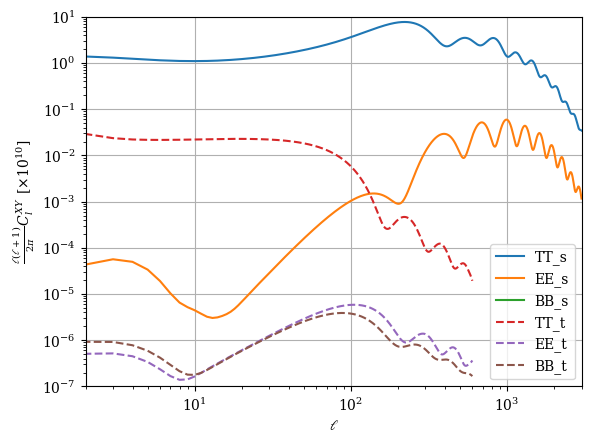

In [32]:

for key in PlanckAni_s.keys():
    plt.loglog(ell, PlanckAni_s[key], "-", label = str(key))

for key in PlanckAni_t.keys():
    plt.loglog(ellt, PlanckAni_t[key], "--", label = str(key))

plt.xlim([2,l_max_scalars])
plt.ylim([1.e-7,10])

plt.xlabel(r"$\ell$")
plt.ylabel(r"$\frac{\ell (\ell+1)}{2\pi} C_l^{XY} \,\,\, [\times 10^{10}]$")
plt.grid()
plt.legend()

Habiendo obtenido los espectros, pocederé a encontrar los máximos locales y la amplitud en esos puntos. Para ello, me valdré de la función `find_peaks` de Scipy sin ningun parámetro de filtro para los máximos. La aplicaré a cada uno de los espectros de angulares mostrados anteriormente y guadaré la lista de los $\ell$ correspondientes a esos máximos en un diccionario, separando los escalares y los tensoriales.

In [33]:
from scipy.signal import find_peaks

ScalarPeaks = {}
TensorPeaks = {}

for key in PlanckAni_s.keys():
    peaks_for_key, peak_prop = find_peaks(PlanckAni_s[key])
    ScalarPeaks[key] = peaks_for_key

for key in PlanckAni_t.keys():
    peaks_for_key, peak_prop = find_peaks(PlanckAni_t[key])
    TensorPeaks[key] = peaks_for_key


Ahora volveré a realizar la última figura, agregando además los máximos encontrados.

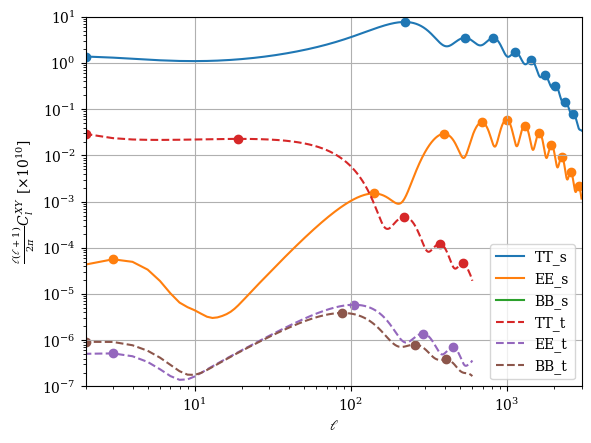

In [34]:
for key in PlanckAni_s.keys():
    plt.loglog(ell, PlanckAni_s[key], "-", label = str(key))

for key in PlanckAni_t.keys():
    plt.loglog(ellt, PlanckAni_t[key], "--", label = str(key))

for key in ScalarPeaks.keys():
    plt.scatter(ScalarPeaks[key], PlanckAni_s[key][ScalarPeaks[key]])

for key in TensorPeaks.keys():
    plt.scatter(TensorPeaks[key], PlanckAni_t[key][TensorPeaks[key]])

plt.xlim([2,3000])
plt.ylim([1.e-7,10])

plt.xlabel(r"$\ell$")
plt.ylabel(r"$\frac{\ell (\ell+1)}{2\pi} C_l^{XY} \,\,\, [\times 10^{10}]$")
plt.grid()
plt.legend()

El máximo de menor $\ell$ se encuentra a grandes escalas angulares, en el *plateu*, por lo que no es el máximo acústico. A partir del segundo máximo encontrado se ven los máximos acústicos.
Habiendo corroborado que hemos encontrado los máximos de cada uno de los espectros, pasaré a colocarlos en una tabla y a  calcular los cocientes entre las amplitudes de los picos de temperatura y los modos de polarización tanto escalares como tensoriales.

In [35]:
Comparison = DataFrame()

from pandas import concat

for key in ScalarPeaks.keys():
    Comparison = concat([Comparison, DataFrame(PlanckAni_s[key][ScalarPeaks[key]], columns=[key+"_max"])], axis=1)

for key in TensorPeaks.keys():
    Comparison = concat([Comparison, DataFrame(PlanckAni_t[key][TensorPeaks[key]], columns=[key+"_max"])], axis=1)

Comparison["TT_s_max/EE_s_max"] = Comparison["TT_s_max"]/Comparison["EE_s_max"]

Comparison["TT_t_max/EE_t_max"] = Comparison["TT_t_max"]/Comparison["EE_t_max"]

Comparison["TT_t_max/BB_t_max"] = Comparison["TT_t_max"]/Comparison["BB_t_max"]

Comparison


,TT_s_max,EE_s_max,BB_s_max,TT_t_max,EE_t_max,BB_t_max,TT_s_max/EE_s_max,TT_t_max/EE_t_max,TT_t_max/BB_t_max
0,1.383467,0.000057,NaN,0.029169,5.186040e-07,9.232205e-07,24477.782417,56245.834506,31595.179895
1,7.735827,0.001502,NaN,0.022822,5.855283e-06,3.890634e-06,5151.363839,3897.629027,5865.810689
2,3.512191,0.029307,NaN,0.000466,1.388692e-06,8.067024e-07,119.841184,335.926049,578.277386
3,3.480994,0.051950,NaN,0.000123,7.028476e-07,3.829104e-07,67.007168,175.295458,321.761953
4,1.703919,0.059585,NaN,0.000046,NaN,NaN,28.596301,NaN,NaN
5,1.138344,0.043829,NaN,NaN,NaN,NaN,25.972330,NaN,NaN
6,0.545042,0.030484,NaN,NaN,NaN,NaN,17.879340,NaN,NaN
7,0.316702,0.016741,NaN,NaN,NaN,NaN,18.917268,NaN,NaN
8,0.146813,0.009212,NaN,NaN,NaN,NaN,15.936775,NaN,NaN
9,0.079596,0.004347,NaN,NaN,NaN,NaN,18.312341,NaN,NaN


En general, notamos que los máximos escalares tienen amplitudes mayores a las tensoriales dado que $r=0,1$. También la amplitud del espectro angular de perturbaciones en temperatura es mayor a la de modos de polarización E y este, a su vez, es mayor al de modos de polarización B. ESto se condice con la facilidad que existió para encontrar cada una de estas perturbaciones. Primero se encontraron las de la temperatura, ya se encontraron la de los modos E de polarización y continuamos buscando las de los modos B (aunque ya encontramos las perturbaciones escalares producidas por el lensing, que estudiaremos luego).
De la columna `TT_s_max/EE_s_max` encontramos que el segundo máximo (el correspondiente a las oscilaciones acústicas) es miles de veces mayor en la temperatura que en los modos E de polarización. Lo mismo sucede entre las perturbaciones tensoriales de la temperatura, dado por `TT_t_max/EE_t_max	`, y los modos E de polarización o entre ambos modos de polarización, se ve en `TT_t_max/BB_t_max`.

En lo siguiente, definiré una función que (si bien es muy ineficiente) nos permitirá el calculo de los espectros angulares de potencias variando en $\pm 5 \%$ y $\pm 10 \%$ a un único parámetro del modelo $\Lambda CDM$, que podremos seleccionar con una vairable `str`. Además, esta función reordenará las listas de una manera más cómoda para trabajar.

In [36]:
ModObParams, ModObValues = VarParam(planck_18, "Omega_b", [0.9, 0.95, 1, 1.05, 1.1])
ModOcdmParams, ModOcdmValues = VarParam(planck_18, "Omega_cdm", [0.9, 0.95, 1, 1.05, 1.1])
ModnsParams, ModnsValues = VarParam(planck_18, "n_s", [0.9, 0.95, 1, 1.05, 1.1])
ModtreioParams, ModtreioValues = VarParam(planck_18, "tau_reio", [0.9, 0.95, 1, 1.05, 1.1])
ModAsParams, ModAsValues = VarParam(planck_18, "A_s", [0.9, 0.95, 1, 1.05, 1.1])

In [37]:
def Get_s_Cls(params, l_max_s):

    AuxDic = params.copy()
    AuxDic.pop("H0",0)
    AuxDic.pop("ombh2",0)
    AuxDic.pop("omch2",0)
    AuxDic.pop("Y_He",0)

    M = Class()
    M.empty()
    M.set(AuxDic)
    M.set({'output':'tCl,pCl','modes':'s','lensing':'no',
        'l_max_scalars':l_max_s})
    M.compute()
    Cls = M.raw_cl(l_max_s)
    
    ell = Cls['ell']
    factor = 1.e10*ell*(ell+1.)/2./np.pi

    output = {"ell": ell, "TT_s": factor*Cls['tt'], "EE_s":factor*Cls['ee']}
    
    return output

In [38]:
ModObCls = [Get_s_Cls(x, l_max_scalars) for x in ModObParams]
ModOcCls = [Get_s_Cls(x, l_max_scalars) for x in ModObParams]
ModnsCls = [Get_s_Cls(x, l_max_scalars) for x in ModObParams]
ModtreioCls = [Get_s_Cls(x, l_max_scalars) for x in ModObParams]
ModAsCls = [Get_s_Cls(x, l_max_scalars) for x in ModObParams]

Primero usaré la función creada para variar $\Omega_b$.

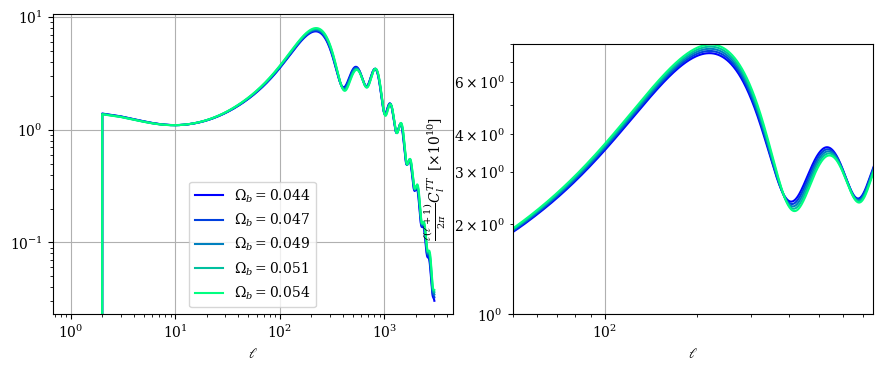

In [39]:
fig = plt.figure(1, figsize=(4, 3))
ax1 = fig.add_axes([0, 0, 1, 1])
ax2 = fig.add_axes([1.15, 0, 0.9, 0.9])

for ax in fig.axes:
    ax.set_xlabel(r"$\ell$")
    ax.grid()
    
    for i in range(len(ModObCls)):
        ax.loglog(ModObCls[i]["ell"], ModObCls[i]["TT_s"], label = r"$\Omega_b = $"+str(round(ModObValues[i], 3)), color = cmap(i/(5-1)))

ax2.set(xlim=[50,750], ylim=[1.e-0,8])

plt.xlabel(r"$\ell$")
plt.ylabel(r"$\frac{\ell (\ell+1)}{2\pi} C_l^{TT} \,\,\, [\times 10^{10}]$")

ax1.legend()

Como podemos ver, aumentar la componente de materia bariónica del universo puede generar que el primer máximo acústico aumente su amplitud y se desplace hacia un $\ell$ ligeramente mayor. El segundo máximo acústico disminuye su amplitud y también se desplaza a la derecha. Por otro lado, disminuir esta componente no pareciera tener impacto significativo en el espectro.


A continuación usaré la función creada para variar $\Omega_{cdm}$.

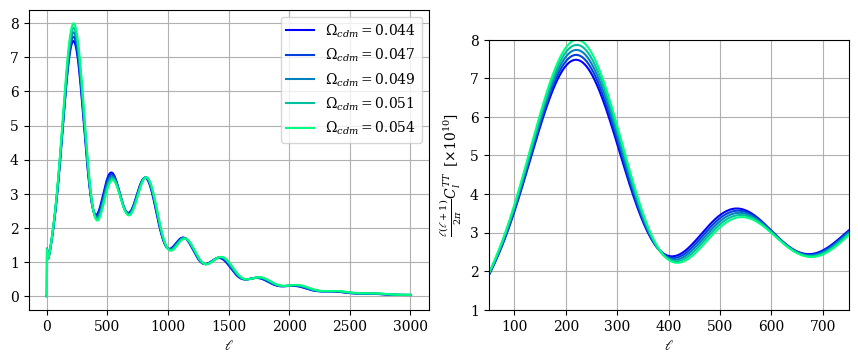

In [40]:
fig = plt.figure(1, figsize=(4, 3))
ax1 = fig.add_axes([0, 0, 1, 1])
ax2 = fig.add_axes([1.15, 0, 0.9, 0.9])

for ax in fig.axes:
    ax.set_xlabel(r"$\ell$")
    ax.grid()
    
    for i in range(len(ModOcCls)):
        ax.plot(ModOcCls[i]["ell"], ModOcCls[i]["TT_s"], label = r"$\Omega_{cdm} = $"+str(round(ModObValues[i], 3)), color = cmap(i/(5-1)))

ax2.set(xlim=[50,750], ylim=[1.e-0,8])

plt.xlabel(r"$\ell$")
plt.ylabel(r"$\frac{\ell (\ell+1)}{2\pi} C_l^{TT} \,\,\, [\times 10^{10}]$")

ax1.legend()

Existe un apreciable decesno en la amplitud del espectro cuando $\Omega_{cdm}$ decrece. Además se nota un pequeño desplazamiento a la izquierda de los máximos y mínimos.

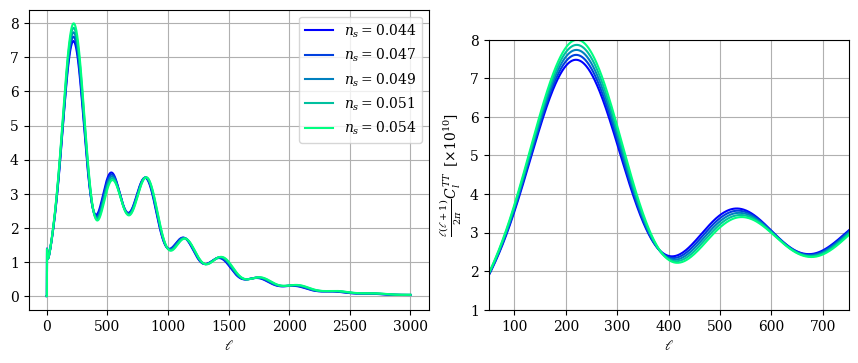

In [41]:
fig = plt.figure(1, figsize=(4, 3))
ax1 = fig.add_axes([0, 0, 1, 1])
ax2 = fig.add_axes([1.15, 0, 0.9, 0.9])

for ax in fig.axes:
    ax.set_xlabel(r"$\ell$")
    ax.grid()
    
    for i in range(len(ModnsCls)):
        ax.plot(ModnsCls[i]["ell"], ModnsCls[i]["TT_s"], label = r"$n_s = $"+str(round(ModObValues[i], 3)), color = cmap(i/(5-1)))

ax2.set(xlim=[50,750], ylim=[1.e-0,8])

plt.xlabel(r"$\ell$")
plt.ylabel(r"$\frac{\ell (\ell+1)}{2\pi} C_l^{TT} \,\,\, [\times 10^{10}]$")

ax1.legend()

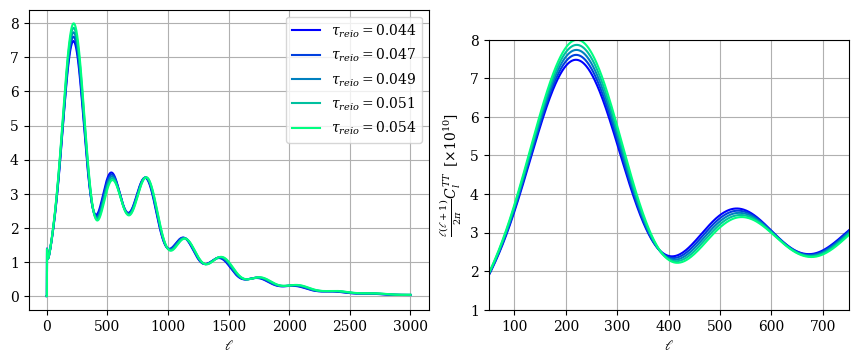

In [42]:
fig = plt.figure(1, figsize=(4, 3))
ax1 = fig.add_axes([0, 0, 1, 1])
ax2 = fig.add_axes([1.15, 0, 0.9, 0.9])

for ax in fig.axes:
    ax.set_xlabel(r"$\ell$")
    ax.grid()
    
    for i in range(len(ModtreioCls)):
        ax.plot(ModtreioCls[i]["ell"], ModtreioCls[i]["TT_s"], label = r"$\tau_{reio} = $"+str(round(ModObValues[i], 3)), color = cmap(i/(5-1)))

ax2.set(xlim=[50,750], ylim=[1.e-0,8])

plt.xlabel(r"$\ell$")
plt.ylabel(r"$\frac{\ell (\ell+1)}{2\pi} C_l^{TT} \,\,\, [\times 10^{10}]$")

ax1.legend()

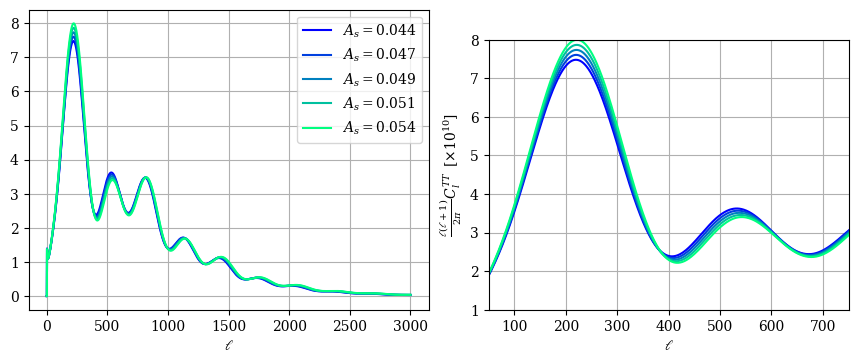

In [43]:
fig = plt.figure(1, figsize=(4, 3))
ax1 = fig.add_axes([0, 0, 1, 1])
ax2 = fig.add_axes([1.15, 0, 0.9, 0.9])

for ax in fig.axes:
    ax.set_xlabel(r"$\ell$")
    ax.grid()
    
    for i in range(len(ModAsCls)):
        ax.plot(ModAsCls[i]["ell"], ModAsCls[i]["TT_s"], label = r"$A_s = $"+str(round(ModObValues[i], 3)), color = cmap(i/(5-1)))

ax2.set(xlim=[50,750], ylim=[1.e-0,8])

plt.xlabel(r"$\ell$")
plt.ylabel(r"$\frac{\ell (\ell+1)}{2\pi} C_l^{TT} \,\,\, [\times 10^{10}]$")

ax1.legend()

In [44]:

def Variate_param_in_Cls(parameters, param_to_variate):
    TT_s_VarAni = [[], [], [], [], []]
    TT_t_VarAni = [[], [], [], [], []]
    EE_s_VarAni = [[], [], [], [], []]
    EE_t_VarAni = [[], [], [], [], []]
    BB_lens_VarAni = [[], [], [], [], []]
    BB_t_VarAni = [[], [], [], [], []]
    
    j = 0
    
    for i in [0.9, 0.95, 1, 1.05, 1.1]:
        parameters[str(param_to_variate)] = parameters[str(param_to_variate)]*i
        ell, ellt, VarAni_s, VarAni_t = Get_Cls(parameters, 3000, 600)
        TT_s_VarAni[j] = VarAni_s["TT_s"]
        TT_t_VarAni[j] = VarAni_t["TT_t"]
        EE_s_VarAni[j] = VarAni_s["EE_s"]
        EE_t_VarAni[j] = VarAni_t["EE_t"]
        BB_lens_VarAni[j] = VarAni_s["BB_lens"]
        BB_t_VarAni[j] = VarAni_t["BB_t"]
        j = j+1
    
    return {
        "ell" : ell,
        "ellt": ellt,
        "TT_s_VarAni": TT_s_VarAni,
        "TT_t_VarAni": TT_t_VarAni,
        "EE_s_VarAni": EE_s_VarAni,
        "EE_t_VarAni": EE_t_VarAni,
        "BB_lens_VarAni": BB_lens_VarAni,
        "BB_t_VarAni": BB_t_VarAni
    }

In [45]:
Variations = Variate_param_in_Cls(planck_18, "Omega_b")


KeyError: 'BB_lens'

In [ ]:

plt.plot(Variations["ell"], Variations["TT_s_VarAni"][2])
plt.fill_between(Variations["ell"], Variations["TT_s_VarAni"][4], Variations["TT_s_VarAni"][0], alpha = 0.3, color = (1,0,0))
plt.fill_between(Variations["ell"], Variations["TT_s_VarAni"][3], Variations["TT_s_VarAni"][1], alpha = 0.5, color = (1,0,0))

plt.xlim([50,750])
plt.ylim([1.e-0,8])

plt.xlabel(r"$\ell$")
plt.ylabel(r"$\frac{\ell (\ell+1)}{2\pi} C_l^{XY} \,\,\, [\times 10^{10}]$")

In [ ]:
Variations = Variate_param_in_Cls(planck_18, "Omega_cdm")

In [ ]:

plt.plot(Variations["ell"], Variations["TT_s_VarAni"][2])
plt.fill_between(Variations["ell"], Variations["TT_s_VarAni"][4], Variations["TT_s_VarAni"][0], alpha = 0.3, color = (1,0,0))
plt.fill_between(Variations["ell"], Variations["TT_s_VarAni"][3], Variations["TT_s_VarAni"][1], alpha = 0.5, color = (1,0,0))

plt.xlim([50,750])
plt.ylim([2,8.5])

plt.xlabel(r"$\ell$")
plt.ylabel(r"$\frac{\ell (\ell+1)}{2\pi} C_l^{XY} \,\,\, [\times 10^{10}]$")

In [ ]:
M.empty() # reset input parameters to default, before passing a new parameter set
M.set(planck_18)
M.set({'output':'tCl,pCl,lCl','modes':'s,t','lensing':'yes','n_s':0.9660499,'r':0.1,'n_t':0,
    'l_max_scalars':l_max_scalars,'l_max_tensors':l_max_tensors})
M.compute()
Cl_tot = M.raw_cl(l_max_s)
Cl_lensed = M.lensed_cl(l_max_s)

## Bibliografía

[1] Aghanim, N., Akrami, Y., Ashdown, M., Aumont, J., Baccigalupi, C., Ballardini, M., ... & Roudier, G. (2020). Planck 2018 results-VI. Cosmological parameters. Astronomy & Astrophysics, 641, A6.

[2] Tristram, M., Banday, A. J., Douspis, M., Garrido, X., Górski, K. M., Henrot-Versillé, S., ... & Scott, D. (2024). Cosmological parameters derived from the final Planck data release (PR4). Astronomy & Astrophysics, 682, A37.

[3] Madau, P., & Dickinson, M. (2014). Cosmic star-formation history. Annual Review of Astronomy and Astrophysics, 52(1), 415-486.

[4]Steigman, G. (2002). Primordial alchemy: from the Big Bang to the present Universe. arXiv preprint astro-ph/0208186.